In [1]:
%reload_kedro

2020-04-10 13:38:37,249 - root - INFO - ** Kedro project Dynamic Topic Modeling
2020-04-10 13:38:37,251 - root - INFO - Defined global variable `context` and `catalog`
Traceback (most recent call last):
  File "/home/ridouane/anaconda3/envs/dynamic-topic-modeling/lib/python3.6/site-packages/kedro/cli/cli.py", line 589, in load_entry_points
    entry_point_commands.append(entry_point.load())
  File "/home/ridouane/anaconda3/envs/dynamic-topic-modeling/lib/python3.6/site-packages/pkg_resources/__init__.py", line 2449, in load
    self.require(*args, **kwargs)
  File "/home/ridouane/anaconda3/envs/dynamic-topic-modeling/lib/python3.6/site-packages/pkg_resources/__init__.py", line 2472, in require
    items = working_set.resolve(reqs, env, installer, extras=self.extras)
  File "/home/ridouane/anaconda3/envs/dynamic-topic-modeling/lib/python3.6/site-packages/pkg_resources/__init__.py", line 792, in resolve
    raise VersionConflict(dist, req).with_context(dependent_req)
pkg_resources.Versio

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import jensenshannon
from sklearn.manifold import MDS

In [3]:
vocab = catalog.load('dictionary')
train_docs = catalog.load('train_docs')

2020-04-10 13:39:06,851 - kedro.io.data_catalog - INFO - Loading data from `dictionary` (DictionaryDataSet)...
2020-04-10 13:39:06,852 - gensim.utils - INFO - loading Dictionary object from data/05_model_input/dictionary.dict
2020-04-10 13:39:06,855 - gensim.utils - INFO - loaded data/05_model_input/dictionary.dict
2020-04-10 13:39:06,856 - kedro.io.data_catalog - INFO - Loading data from `train_docs` (PickleLocalDataSet)...


In [4]:
def extract_top_n_words(topic_distributions, dictionary, topic_id, top_n):
    top_n_words = [dictionary[np.argsort(topic_distributions[topic_id])[-i-1]] for i in range(top_n)]
    top_n_freqs = [np.sort(topic_distributions[topic_id])[-i-1] for i in range(top_n)]
    return top_n_words, top_n_freqs

def calculate_topic_distances(topic_distributions):
    num_topics = len(topic_distributions)
    distances = np.zeros((num_topics, num_topics))
    for i in range(num_topics):
        for j in range(num_topics):
            topic_i, topic_j = topic_distributions[i], topic_distributions[j]
            distances[i][j] = jensenshannon(topic_i, topic_j)
    return distances

def show_most_m_represantative_docs(doc_topic, m, docs, topic_id):
    indices_max = np.argsort(doc_topic[:,topic_id])[-m:]
    verbatims = []
    for idx in reversed(indices_max):
        doc = docs[idx]
        verbatims.append(' '.join(list(doc)))
    return verbatims

def occ_dict(doc):
    occurences_dict = {}
    for word in doc:
        if word in occurences_dict:
            occurences_dict[word] += 1
        else:
            occurences_dict[word] = 1
    return occurences_dict

def get_Dwi(wi, doc_dicts):
    Dwi = 0
    for doc_dict in doc_dicts:
        if wi in doc_dict:
            Dwi += doc_dict[wi]
    return Dwi

def get_Dwiwj(wi, wj, doc_dicts):
    Dwiwj = 0
    for doc_dict in doc_dicts:
        if wi in doc_dict and wj in doc_dict:
            Dwiwj += doc_dict[wi] * doc_dict[wj]
    return Dwiwj

def topic_coherence(topic_distributions, dictionary, topic_id, top_n, docs, method='umass', eps=1e-5):
    top_words, _ = extract_top_n_words(topic_distributions, dictionary, topic_id, top_n)

    N = top_n - 1

    D = 0
    for doc in docs:
        D += len(doc)
    #D = len(docs)

    # remplacer par un CountVectorizer
    doc_dicts = [occ_dict(doc) for doc in docs]

    score = 0.
    for i in range(1, N):
        for j in range(i):
            wi = top_words[i]
            wj = top_words[j]

            Dwj = get_Dwi(wj, doc_dicts)
            Dwiwj = get_Dwiwj(wi, wj, doc_dicts)

            pwj = Dwj / D
            pwiwj = Dwiwj / D

            # umass
            if method == 'umass':
                score += np.log((pwiwj + eps) / pwj)

            # pmi
            elif method == 'pmi':
                Dwi = get_Dwi(wi, doc_dicts)
                pwi = Dwi / D
                score += np.log((pwiwj + eps) / (pwi * pwj))

            # npmi
            elif method == 'npmi':
                Dwi = get_Dwi(wi, doc_dicts)
                pwi = Dwi / D

                if Dwiwj == 0:
                    score += -1.
                elif Dwiwj == Dwi and Dwiwj == Dwj:
                    score += 1.
                else:
                    score += np.log((pwiwj + eps) / (pwi * pwj)) / (- np.log(pwiwj + eps))

    return score / (2 * N * (N - 1))

def topic_diversity(topic_distributions, dictionary, top_n):
    top_words = []
    num_topics = len(topic_distributions)
    for k in range(num_topics):
        tmp, _ = extract_top_n_words(topic_distributions, dictionary, k, top_n)
        top_words += tmp
    return len(np.unique(top_words)) / len(top_words)

In [25]:
def visualize_topics(beta, dictionary, num_topics, top_n_show=5):
    distances = calculate_topic_distances(beta)
    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
    pos = mds.fit(distances).embedding_
    plt.figure(figsize=(16, 16))
    plt.scatter(pos[:, 0], pos[:, 1], s=100, lw=0)

    words = [[]]*num_topics
    for topic_id in range(num_topics):
        top_n_words, _ = extract_top_n_words(beta, dictionary, topic_id, top_n_show)
        words[topic_id] = top_n_words
    for topic_id in range(num_topics):
        plt.text(pos[topic_id, 0]+0.01, pos[topic_id, 1]+0.01*top_n_show, 'Topic '+str(topic_id), c='blue')
        for k in range(top_n_show):
            plt.text(pos[topic_id, 0]+0.01, pos[topic_id, 1]-(k+1)*0.01+0.01*top_n_show, words[topic_id][k])

    plt.show()

In [ ]:
num_topics=50

## Clustering in word space

2020-04-10 13:42:30,364 - kedro.io.data_catalog - INFO - Loading data from `beta` (PickleLocalDataSet)...
2020-04-10 13:42:30,365 - kedro.io.data_catalog - INFO - Loading data from `theta` (PickleLocalDataSet)...


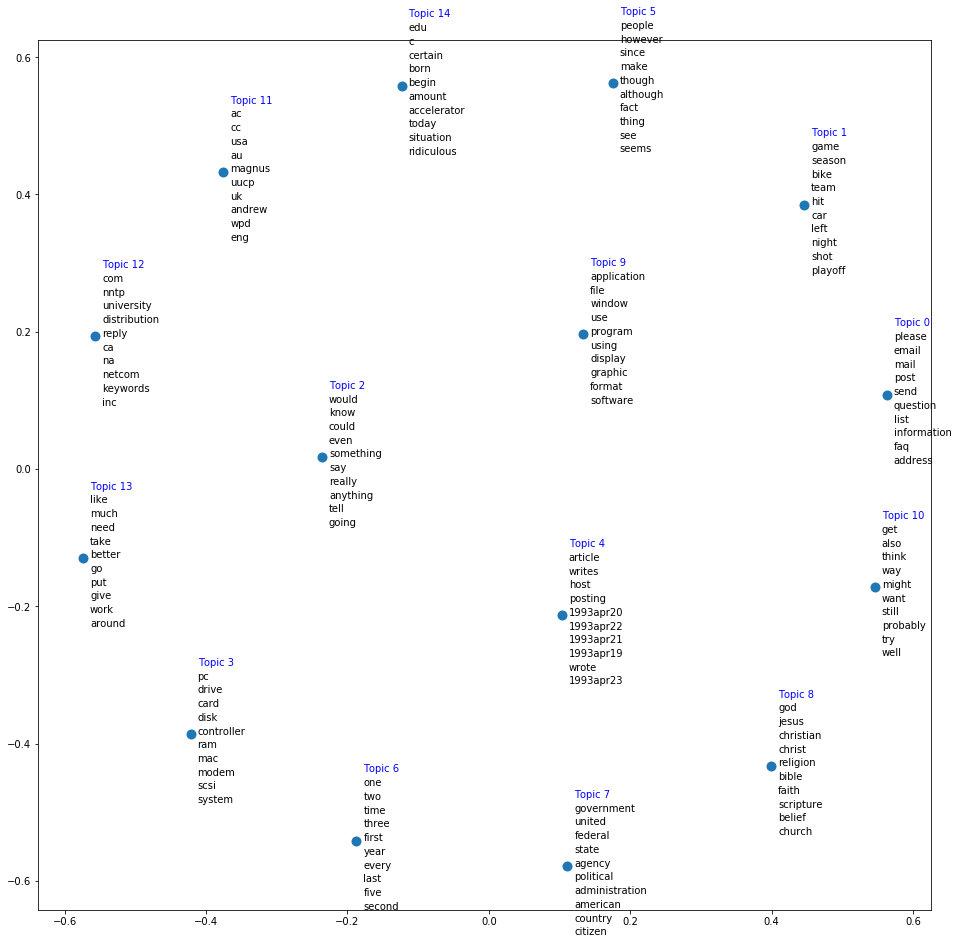

In [19]:
beta, theta = catalog.load('beta'), catalog.load('theta')
visualize_topics(beta, vocab, num_topics, top_n_show=10)

## Clustering in doc space

2020-04-10 13:43:59,034 - kedro.io.data_catalog - INFO - Loading data from `beta` (PickleLocalDataSet)...
2020-04-10 13:43:59,036 - kedro.io.data_catalog - INFO - Loading data from `theta` (PickleLocalDataSet)...


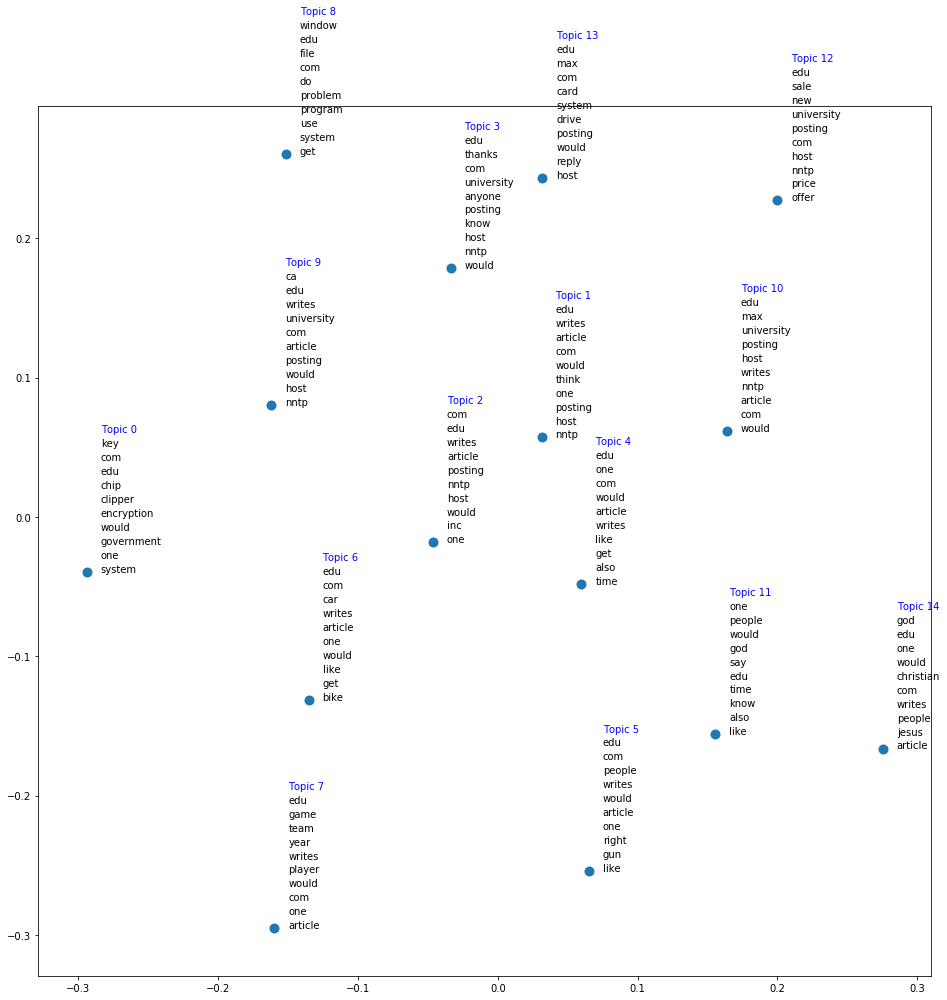

In [22]:
beta, theta = catalog.load('beta'), catalog.load('theta')
visualize_topics(beta, vocab, num_topics, top_n_show=10)

## LDA

2020-04-10 13:51:44,378 - kedro.io.data_catalog - INFO - Loading data from `beta` (PickleLocalDataSet)...
2020-04-10 13:51:44,384 - kedro.io.data_catalog - INFO - Loading data from `theta` (PickleLocalDataSet)...


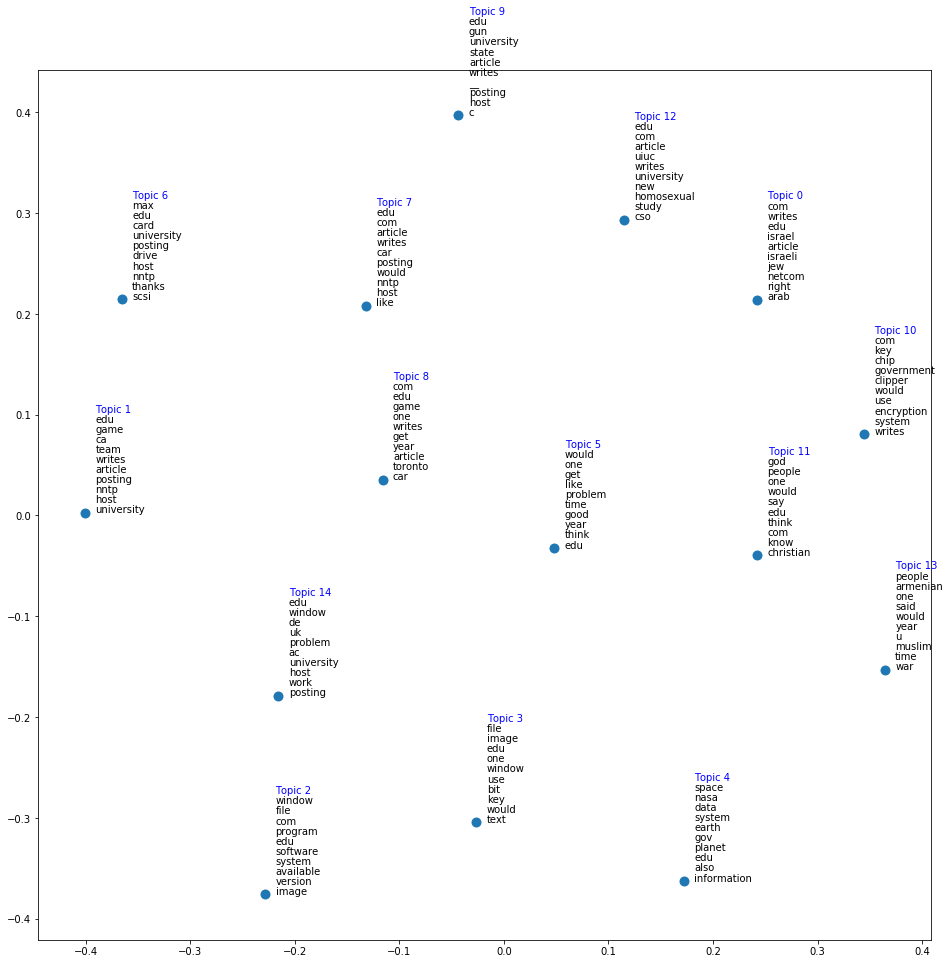

In [27]:
beta, theta = catalog.load('beta'), catalog.load('theta')
visualize_topics(beta, vocab, num_topics, top_n_show=10)

## ETM

2020-04-10 13:50:01,446 - kedro.io.data_catalog - INFO - Loading data from `beta` (PickleLocalDataSet)...
2020-04-10 13:50:01,448 - kedro.io.data_catalog - INFO - Loading data from `theta` (PickleLocalDataSet)...


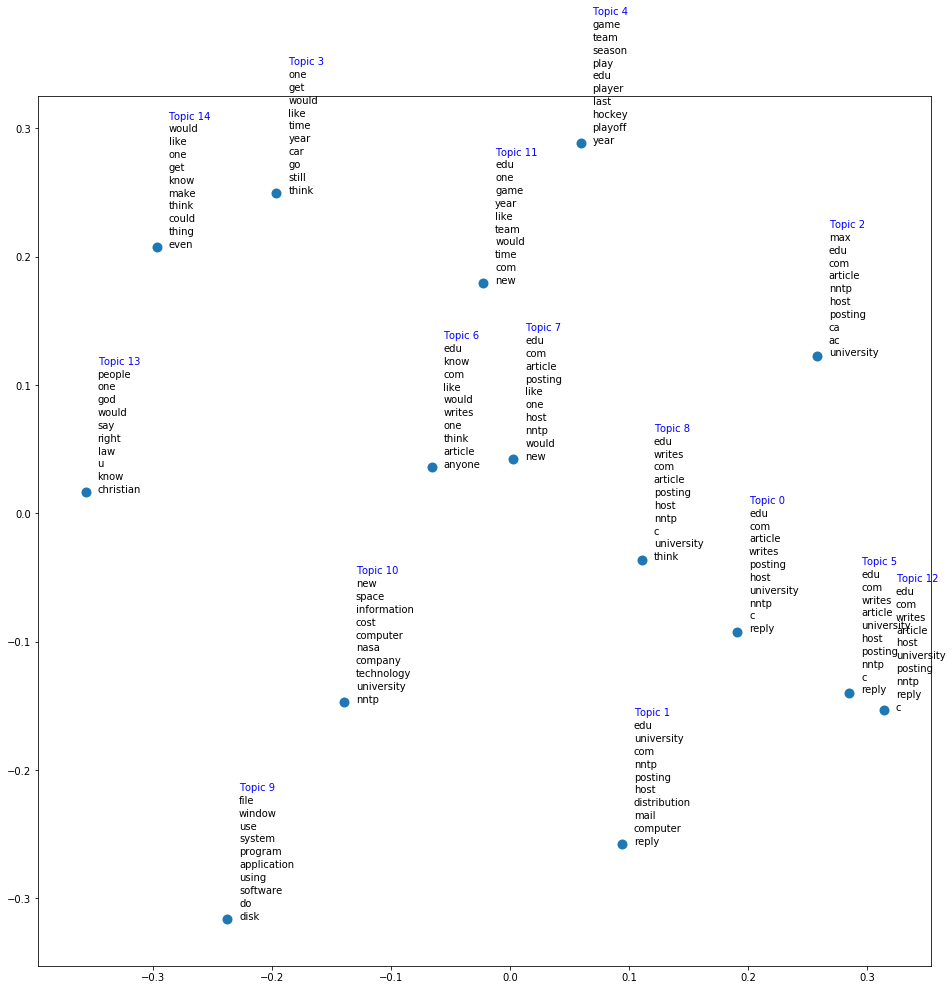

In [26]:
beta, theta = catalog.load('beta'), catalog.load('theta')
visualize_topics(beta, vocab, num_topics, top_n_show=10)